In [24]:
import numpy as np
import scipy.misc
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from math import trunc

%matplotlib inline

## Calibrate Camera

In [2]:
def calibrate_camera(images, nx=9, ny=6, show=False):
    
    N = len(images)
    if show:
        fig=plt.figure(figsize=(18, 16))
    columns = 4
    rows = int(np.ceil(N / 3))

    # Store object points and image points from all images
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane

    # Prepare object points
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) # x, y coordinates
    # iterate through all image files
    for i, fname in enumerate(images):
        img = mpimg.imread(fname)
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Find chessboard corners (for an nx x ny board)
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            # Draw detected corners on an image
            img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        if show:
            fig.add_subplot(rows, columns, i+1)
            plt.imshow(img, cmap='gray')
    if show:
        plt.show()
    # Calibrate camera, given object points, image points, and the shape of the grayscale image
    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [3]:
import glob
images = glob.glob('./camera_cal/calibration*.jpg')

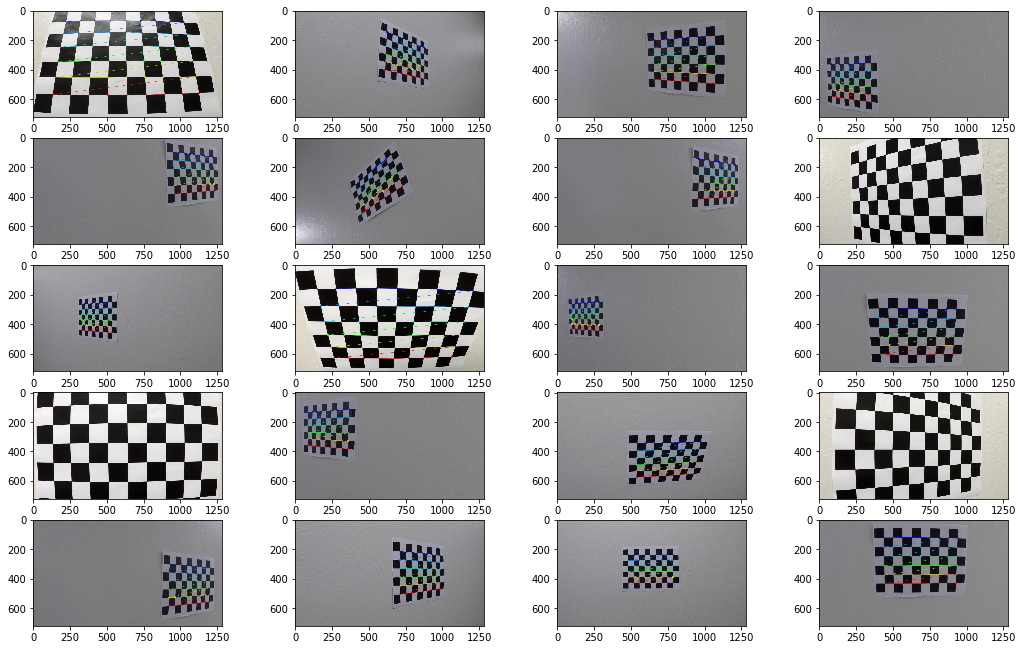

In [4]:
ret, mtx, dist, rvecs, tvecs = calibrate_camera(images, show=True)

In [5]:
image_paths = sorted(glob.glob("./test_images/*.jpg"))
for i, img_path in enumerate(image_paths):
    print(i, img_path)

0 ./test_images/harder_challenge_video_1720.jpg
1 ./test_images/harder_challenge_video_220.jpg
2 ./test_images/harder_challenge_video_3802.jpg
3 ./test_images/harder_challenge_video_4232.jpg
4 ./test_images/harder_challenge_video_610.jpg
5 ./test_images/harder_challenge_video_919.jpg
6 ./test_images/project_video_2204.jpg
7 ./test_images/project_video_2230.jpg
8 ./test_images/project_video_3690.jpg
9 ./test_images/project_video_4164.jpg
10 ./test_images/straight_lines1.jpg
11 ./test_images/straight_lines2.jpg
12 ./test_images/test1.jpg
13 ./test_images/test2.jpg
14 ./test_images/test3.jpg
15 ./test_images/test4.jpg
16 ./test_images/test5.jpg
17 ./test_images/test6.jpg


## Undistort Image

12 ./test_images/test1.jpg


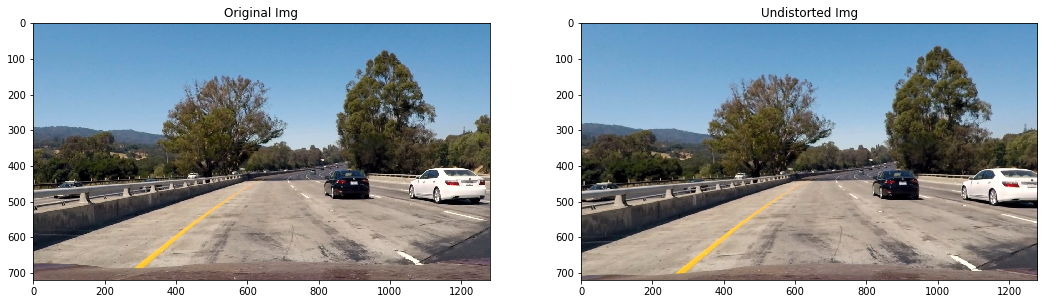

In [6]:
img_idx = 12
img_path = image_paths[img_idx]
print(img_idx, img_path)

fig = plt.figure(figsize=(18, 6))
rows = 1
columns = 2

# Read and display (distorted) test image
img = mpimg.imread(img_path)
fig.add_subplot(rows, columns, 1)
plt.imshow(img)
plt.title("Original Img")

undist_img = cv2.undistort(img, mtx, dist, None, mtx)
fig.add_subplot(rows, columns, 2)
plt.imshow(undist_img)
plt.title("Undistorted Img")

plt.show()

In [7]:
import os.path
img_name = os.path.split(img_path)[1]
scipy.misc.imsave('./output_images/undistort_%s' % img_name, undist_img)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


## Change Color Space

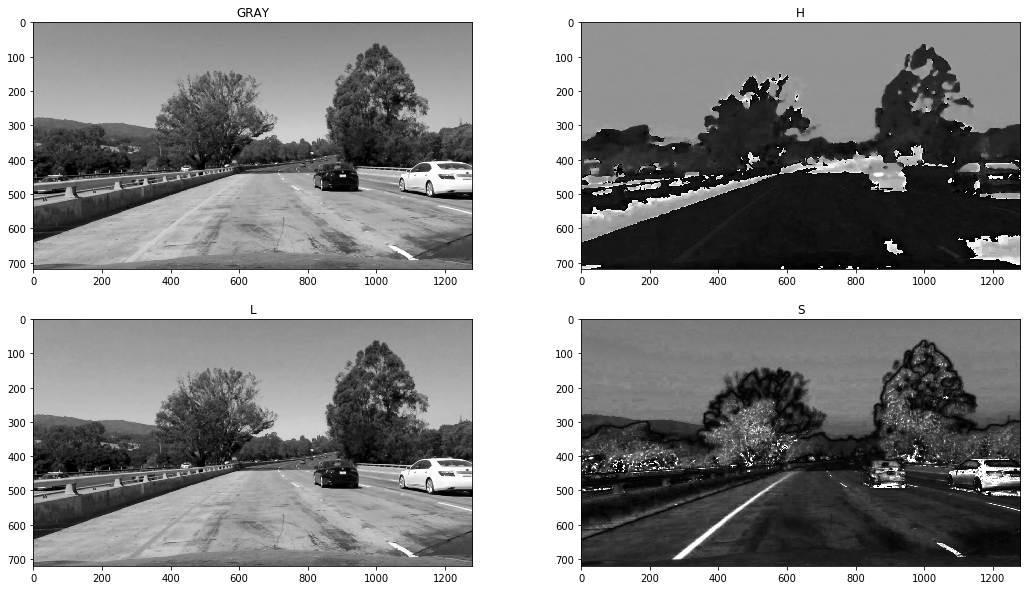

In [8]:
fig = plt.figure(figsize=(18, 10))
hls_img = cv2.cvtColor(undist_img, cv2.COLOR_RGB2HLS)
gray_img = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)
rows = 2
columns = 2
fig.add_subplot(rows, columns, 1)
plt.imshow(gray_img, cmap='gray')
plt.title("GRAY")
for i, l in enumerate(['H', 'L', 'S']):
    fig.add_subplot(rows, columns, i+2)
    plt.imshow(hls_img[:, :, i], cmap='gray')
    plt.title(l)

plt.show()

## Color Transform

In [9]:
def get_scaled_sobel(channel, x=0, y=0):    
    scaled_sobel = np.zeros_like(channel)
    if x == 1:
        # Sobel x
        sobel = cv2.Sobel(channel, cv2.CV_64F, 1, 0)
        abs_sobel = np.absolute(sobel)
        scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
        scaled_sobel += scaled_sobel
    if y == 1:
        # Sobel y
        sobel = cv2.Sobel(channel, cv2.CV_64F, 0, 1)
        abs_sobel = np.absolute(sobel)
        scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
        scaled_sobel += scaled_sobel
    scaled_sobel[scaled_sobel >= 255] = 255
    return scaled_sobel

# Edit this function to create your own pipeline.
def color_pipeline(img, s_thresh=(130, 255), sx_thresh=(40, 80), use_channels = (3, 4, 5)):
    # Returned color_binary NumPy array has the following channels
    channels = ['sxbinary_h', 'sxbinary_l', 'sxbinary_s', 'white_mask', 'yellow_mask', 's_binary']
    
    # Yellow-ish areas in image (in HLS color space)
    hls_yellow_low = np.array([np.round( 42 / 2), np.round(0.15 * 255), np.round(0.30 * 255)])
    hls_yellow_high = np.array([np.round( 60 / 2), np.round(1.00 * 255), np.round(1.00 * 255)])
    # White-ish areas in image (in RGB color space)
    rgb_white_low = np.array([190, 190, 190])
    rgb_white_high = np.array([255, 255, 255])

    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # percent of the top part of the image to be cleared (b/c it's above road level)
    clear_pct = 58
    height, width, depth = img.shape
    # get white parts of the image
    white_mask = cv2.inRange(img, rgb_white_low, rgb_white_high)
    white_mask[white_mask>0] = 1
    white_mask[:clear_pct*height//100,:] = 0
    # get yellow parts of the image
    yellow_mask = cv2.inRange(hls, hls_yellow_low, hls_yellow_high)
    yellow_mask[yellow_mask>0] = 1
    yellow_mask[:clear_pct*height//100,:] = 0
    # clear the bottom right corner (b/c yellow lane marks are expected
    # to be only on the left or upper-right side of the image)
    yellow_mask[2*height//3:, width//2:] = 0
    
    # Scaled Sobel for H channel
    scaled_sobel_h = get_scaled_sobel(hls[:,:,0], x=1, y=0)

    # Scaled Sobel for L channel
    scaled_sobel_l = get_scaled_sobel(hls[:,:,1], x=1, y=0)
    
    # Scaled Sobel for S channel
    scaled_sobel_s = get_scaled_sobel(hls[:,:,2], x=1, y=0)

    # Threshold H channel gradient
    sxbinary_h = np.zeros_like(scaled_sobel_h)
    sxbinary_h[(scaled_sobel_h >= sx_thresh[0]) & (scaled_sobel_h <= sx_thresh[1])] = 1
    sxbinary_h[:2*height//3,:] = 0

    # Threshold L channel gradient
    sxbinary_l = np.zeros_like(scaled_sobel_l)
    sxbinary_l[(scaled_sobel_l >= sx_thresh[0]) & (scaled_sobel_l <= sx_thresh[1])] = 1
    sxbinary_l[:2*height//3,:] = 0

    # Threshold S channel gradient
    sxbinary_s = np.zeros_like(scaled_sobel_s)
    sxbinary_s[(scaled_sobel_s >= sx_thresh[0]) & (scaled_sobel_s <= sx_thresh[1])] = 1
    sxbinary_s[:2*height//3,:] = 0

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1]) & (l_channel > 25) & (l_channel < 230)] = 1
    s_binary[:clear_pct*height//100,:] = 0
    # Stack each channel
    color_binary = np.dstack((sxbinary_h, sxbinary_l, sxbinary_s, white_mask, yellow_mask, s_binary))
    # Get binary image by combining all channels
    
    binary = np.zeros_like(color_binary[:, :, 0])
    for ch in use_channels:
        binary = cv2.bitwise_or(color_binary[:, :, ch], binary)

    # Get the color image by taking only the activated channels
    color = color_binary[:, :, use_channels]*255
    return color_binary, binary, color, channels, use_channels

### Color Transform: Single Image

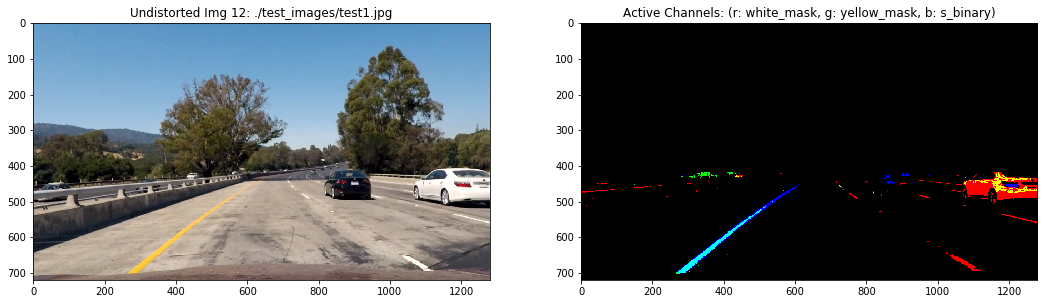

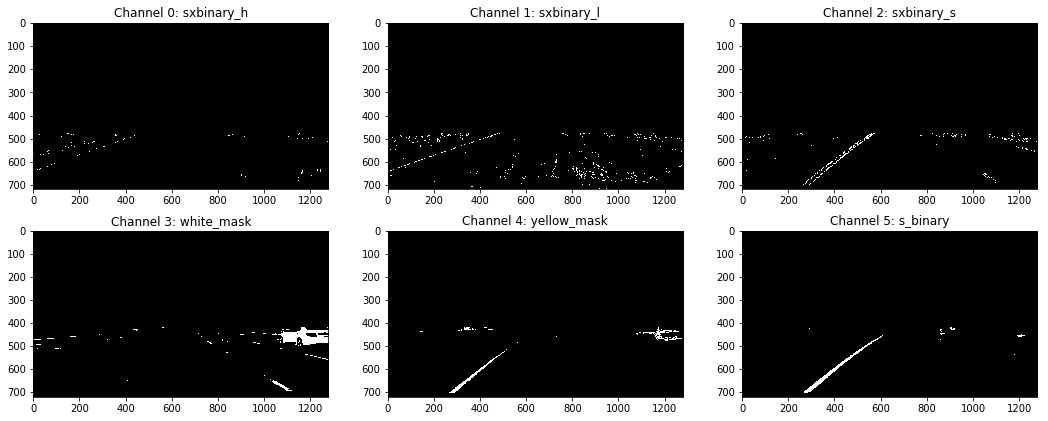

In [10]:
img_idx = 12
img_path = image_paths[img_idx]
# Read and display (distorted) test image
img = mpimg.imread(img_path)
undist_img = cv2.undistort(img, mtx, dist, None, mtx)
fig = plt.figure(figsize=(18, 12))
rows = 1
columns = 2
fig.add_subplot(rows, columns, 1)
plt.imshow(undist_img)
plt.title("Undistorted Img %d: %s" % (img_idx, img_path))

color_binary, binary, color, channels, use_channels = color_pipeline(undist_img)
fig.add_subplot(rows, columns, 2)
plt.imshow(color)
plt.title("Active Channels: (r: %s, g: %s, b: %s)" % tuple(channels[idx] for idx in use_channels))
plt.show()

fig = plt.figure(figsize=(18, 7))
rows = 2
columns = 3
for i, ch in enumerate(channels):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(color_binary[:, :, i], cmap='gray')
    plt.title("Channel %d: %s" % (i, ch))

plt.show()

In [11]:
scipy.misc.imsave('./output_images/binary_combo_%s' % img_name, binary*255)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """Entry point for launching an IPython kernel.


### Color Transform: Multiple Images

In [17]:
fig = plt.figure(figsize=(18, 32))
rows = 8
columns = 3

start_idx = 6
for i, img_path in enumerate(image_paths[start_idx:]):
    if 3*i >= rows*columns:
        break
    img = mpimg.imread(img_path)
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    color_binary, binary, color, channels, use_channels = color_pipeline(undist_img)
    binary_warped = cv2.warpPerspective(binary, M, undist_img.shape[:2][::-1], flags=cv2.INTER_LINEAR)
    out_img, ploty, left_fit, right_fit, left_fitx, right_fitx = fit_polynomial(binary_warped)
    lane_img = draw_lanes(undist_img, binary_warped, Minv, ploty, left_fitx, right_fitx)
    fig.add_subplot(rows, columns, 3*i+1)
    plt.imshow(undist_img)
    plt.title("Img %d: %s" % (start_idx+i, img_path))
    fig.add_subplot(rows, columns, 3*i+2)
    plt.imshow(color)
    plt.title("r: %s, g: %s, b: %s" % tuple(channels[idx] for idx in use_channels))
    fig.add_subplot(rows, columns, 3*i+3)
    plt.imshow(lane_img)
    plt.title("Draw Lanes")
plt.show()

NameError: name 'draw_lanes' is not defined

## Perspective transform

In [13]:
def get_perspective_transform_matrices():
    top_left_x = 596
    top_right_x = 696
    bottom_left_x = 275
    bottom_right_x =1060
    top_y = 450
    bottom_y = 670
    dst_top_y = 100
    dst_bottom_y = 700

    p_src = np.float32([
        [bottom_left_x, bottom_y],
        [top_left_x, top_y],
        [top_right_x, top_y],
        [bottom_right_x, bottom_y]])

    p_dst = np.float32([
        [bottom_left_x, dst_bottom_y],
        [bottom_left_x, dst_top_y],
        [bottom_right_x, dst_top_y],
        [bottom_right_x, dst_bottom_y]])

    return p_src, p_dst

In [14]:
p_src, p_dst = get_perspective_transform_matrices()

# Compute the perspective transform, M, given source and destination points
M = cv2.getPerspectiveTransform(p_src, p_dst)

# Compute the inverse perspective transform
Minv = cv2.getPerspectiveTransform(p_dst, p_src)

x = np.append(p_src[:, 0], p_src[0,0])
y = np.append(p_src[:, 1], p_src[0, 1])

# Straight line for "eye-balling" the quality of the transform
left_x = 300
right_x = 1015
top_y = 0
bottom_y = 720

xl = np.array([left_x, left_x])
xr = np.array([right_x, right_x])
ys = np.array([bottom_y, top_y])

12 ./test_images/test1.jpg


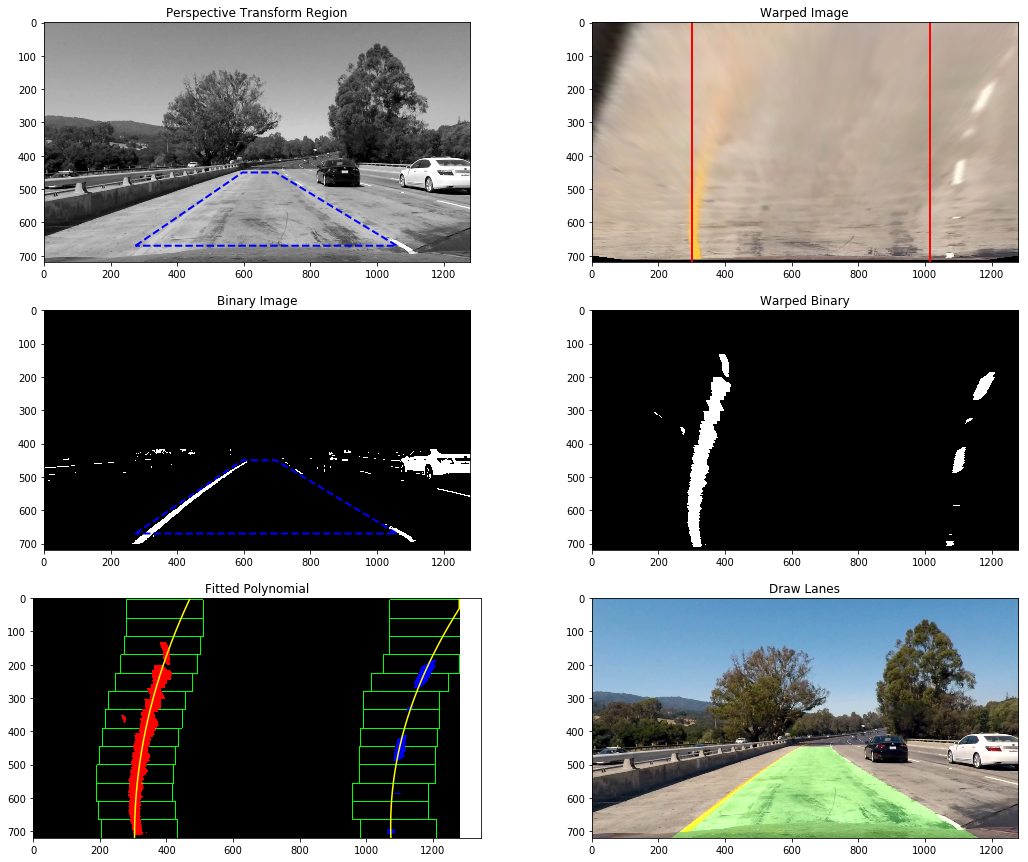

In [88]:
img_idx = 12
img_path = image_paths[img_idx]
print(img_idx, img_path)

# Read and display (distorted) test image
img = mpimg.imread(img_path)
#img = test_img
undist_img = cv2.undistort(img, mtx, dist, None, mtx)
gray = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)

fig = plt.figure(figsize=(18, 15))
rows = 3
columns = 2

fig.add_subplot(rows, columns, 1)
plt.plot(x, y, 'b--', lw=2)
plt.imshow(gray, cmap='gray')
plt.title("Perspective Transform Region")

color_binary, binary, _, _, _ = color_pipeline(undist_img)

# Warp an image using the perspective transform, M
warped = cv2.warpPerspective(undist_img, M, undist_img.shape[:2][::-1], flags=cv2.INTER_LINEAR)

fig.add_subplot(rows, columns, 2)
plt.plot(xl, ys, 'r-', lw=2)
plt.plot(xr, ys, 'r-', lw=2)
plt.imshow(warped)
plt.title("Warped Image")

fig.add_subplot(rows, columns, 3)
plt.plot(x, y, 'b--', lw=2)
plt.imshow(binary, cmap='gray')
plt.title("Binary Image")

fig.add_subplot(rows, columns, 4)
binary_warped = cv2.warpPerspective(binary, M, undist_img.shape[:2][::-1], flags=cv2.INTER_LINEAR)
plt.imshow(binary_warped, cmap='gray')
plt.title("Warped Binary")

out_img, ploty, left_fit, right_fit, left_fitx, right_fitx = fit_polynomial(binary_warped)
fig.add_subplot(rows, columns, 5)
plt.imshow(out_img)
# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.title("Fitted Polynomial")

lane_img = draw_lanes(undist_img, binary_warped, Minv, ploty, left_fitx, right_fitx)
fig.add_subplot(rows, columns, 6)
plt.imshow(lane_img)
plt.title("Draw Lanes")

plt.show()

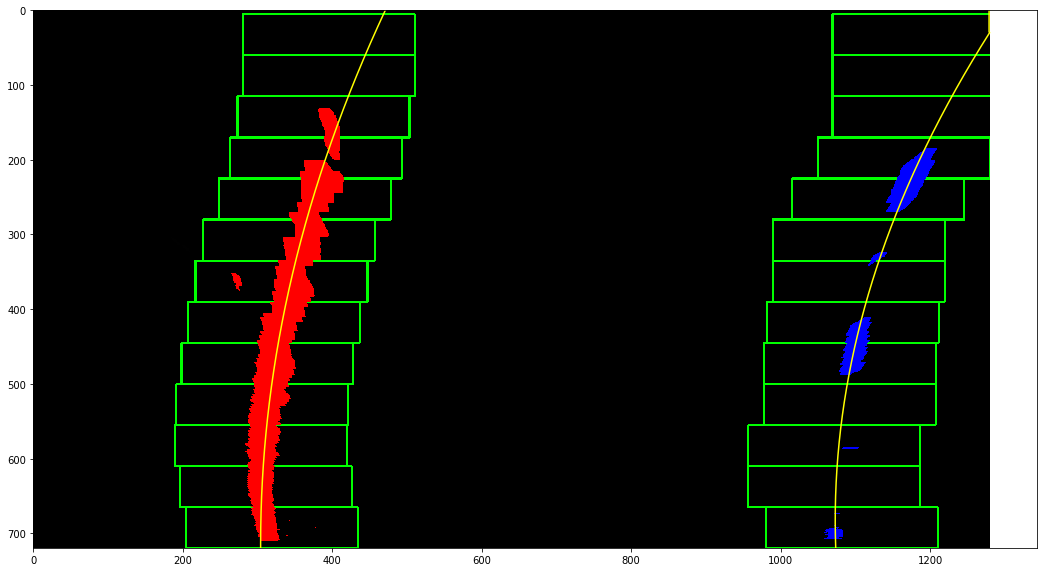

In [67]:
fig = plt.figure(figsize=(18, 16))
plt.imshow(out_img)
# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
img_name = os.path.split(img_path)[1]
plt.savefig('./output_images/color_fit_lines_%s' % img_name)

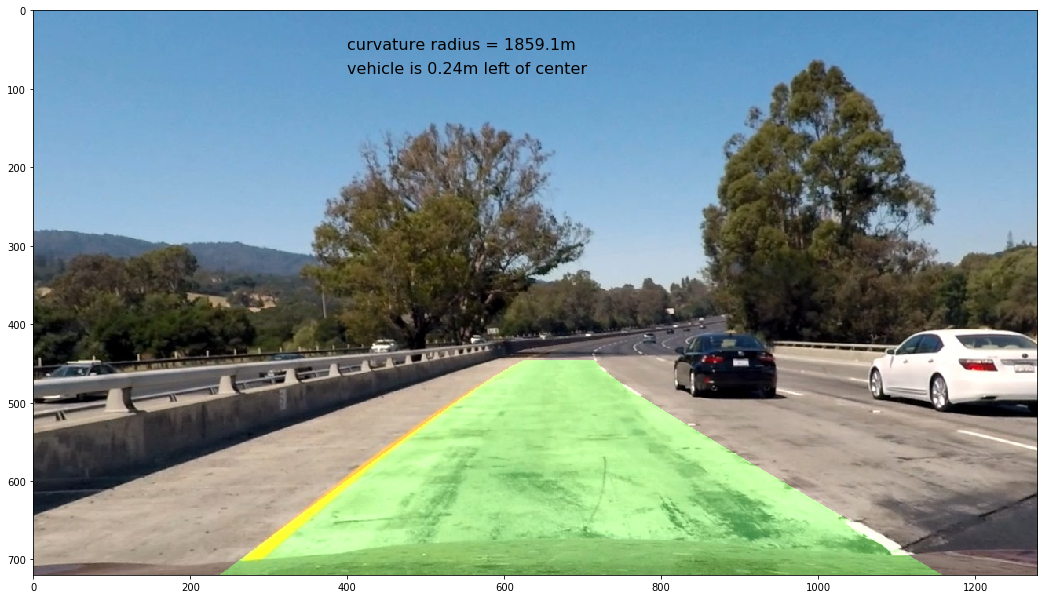

In [100]:
fig = plt.figure(figsize=(18, 16))
plt.imshow(lane_img)

img_name = os.path.split(img_path)[1]
left_curve_rad, right_curve_rad = measure_poly_curvature(ploty, left_fit, right_fit)

fit_range = [left_fitx[-1], right_fitx[-1]]
fit_dist = fit_range[1] - fit_range[0]
lane_center = np.mean(fit_range)
image_center = lane_img.shape[1] // 2
shift_off_center = (lane_center - image_center) * 3.7 / fit_dist

s = "curvature radius = %.1fm" % np.mean([left_curve_rad, right_curve_rad])
plt.text(400, 50, s, fontsize=16)
s = "vehicle is %.2fm %s of center" % (shift_off_center, "left" if shift_off_center >= 0 else "right")
plt.text(400, 80, s, fontsize=16)
plt.savefig('./output_images/example_output_%s' % img_name)

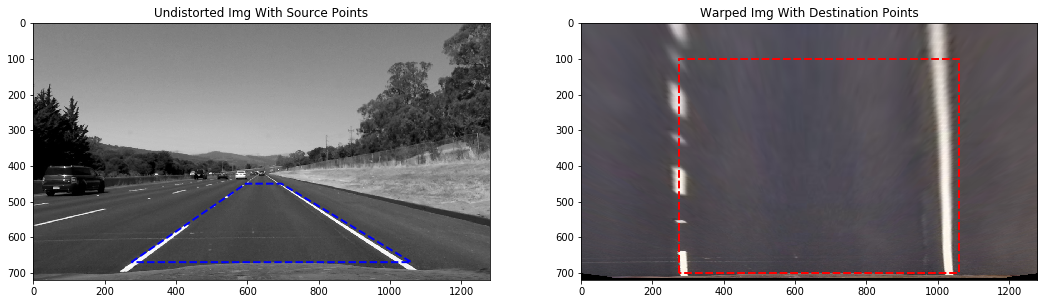

In [65]:
fig = plt.figure(figsize=(18, 10))
rows = 1
columns = 2
fig.add_subplot(rows, columns, 1)
plt.plot(x, y, 'b--', lw=2)
plt.imshow(gray, cmap='gray')
plt.title("Undistorted Img With Source Points")

fig.add_subplot(rows, columns, 2)
xd = np.append(p_dst[:, 0], p_dst[0,0])
yd = np.append(p_dst[:, 1], p_dst[0, 1])
plt.plot(xd, yd, 'r--', lw=2)
plt.plot(xd, yd, 'r--', lw=2)
plt.imshow(warped)
plt.title("Warped Img With Destination Points")
img_name = os.path.split(img_path)[1]
plt.savefig('./output_images/warped_%s' % img_name)

## Finding the Lines: Sliding Window

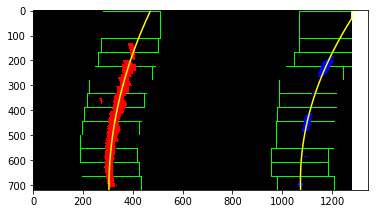

In [16]:
#histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
#plt.plot(histogram)

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    side_clear = 3 * binary_warped.shape[1] // 25
    leftx_base = np.argmax(histogram[side_clear:midpoint]) + side_clear
    rightx_base = np.argmax(histogram[midpoint:-side_clear]) + midpoint
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 13
    # Set the width of the windows +/- margin
    margin = 115
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # flags to stop accumulating left/right pixels when lanes go out of bounds (due to tight curve)
    none_left_count = 0
    none_right_count = 0

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,
                      (win_xleft_low,win_y_low),
                      (win_xleft_high,win_y_high),
                      (0,255,0),
                      2) 
        cv2.rectangle(out_img,
                      (win_xright_low,win_y_low),
                      (win_xright_high,win_y_high),
                      (0,255,0),
                      2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = (
            (nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)
        ).nonzero()[0]
        good_right_inds = (
            (nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
            (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)
        ).nonzero()[0]
        if (win_xleft_low <= 0 and np.sum(good_left_inds) == 0):
            none_left_count += 1
        if (win_xright_high >= binary_warped.shape[1] and np.sum(good_right_inds) == 0):
            none_right_count += 1
        
        # Append these indices to the lists
        if none_left_count < 2:
            left_lane_inds.append(good_left_inds)
        if none_right_count < 2:
            right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    #try:
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    #except ValueError:
    #    pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        # deal with lanes going out-of-bounds on left/right due to curves
        # find first index where the left lane isn't out of bounds
        max_left_idx = np.argmax(left_fitx >= 0)
        left_fitx[:max_left_idx] = 0
        max_right_idx = np.argmax(right_fitx <= binary_warped.shape[1])
        right_fitx[:max_right_idx] = binary_warped.shape[1]-1
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    return out_img, ploty, left_fit, right_fit, left_fitx, right_fitx


out_img, ploty, left_fit, right_fit, left_fitx, right_fitx = fit_polynomial(binary_warped)
plt.imshow(out_img)
# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.show()

## Radius of curvature of the lane and the position of the vehicle with respect to center.

In [18]:
def measure_poly_curvature(ploty, left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # Get the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in meters for both lane lines
#left_curverad, right_curverad = measure_poly_curvature(ploty, left_fit, right_fit)

#print(left_curverad, 'm', right_curverad, 'm')
# Should see values of 533.75 and 648.16 here, if using
# the default `generate_data` function with given seed number

## Drawing

In [19]:
def draw_lanes(undist, warped, Minv, ploty, left_fitx, right_fitx):
    """
    You can then project those lines onto the original image as follows:
    undist - original color image
    warped - a warped binary image
    Minv - inverse perspective transform
    ploty, left_fitx, right_fitx - the x (ploty) and y pixel values of the left/right lines (fit with a quadratic poly)
    """
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

#fig = plt.figure(figsize=(16, 18))
#lane_img = draw_lanes(undist_img, binary_warped, Minv, ploty, left_fitx, right_fitx)
#plt.imshow(lane_img)

In [81]:
class LaneDetector:
    def __init__(self, cal_images, p_src, p_dst):
        """
        cal_images - list of chessboard images at different angles for calibration (with )
        p_src - NumPy array used as source for the Perspective Transform
        p_dst - NumPy array used as destination for the Perspective Transform
        """
        ret, mtx, dist, rvecs, tvecs = calibrate_camera(cal_images)
        self.cameraMatrix = mtx
        self.distCoeffs = dist

        # Initialize perspective transform
        self.M = cv2.getPerspectiveTransform(p_src, p_dst)

        # Initialize inverse perspective transform
        self.Minv = cv2.getPerspectiveTransform(p_dst, p_src)
        
        self.prev_left_fitx = []
        self.prev_right_fitx = []
        self.ploty = None
        
    def __call__(self, img, display=True):
        """ Detect lanes in the image """

        # Undistort
        undist_img = cv2.undistort(img, self.cameraMatrix, self.distCoeffs, None, self.cameraMatrix)
        # Color Transform
        color_binary, binary, color, _, _ = color_pipeline(undist_img)
        
        # Warp (apply perspective transform, M)
        binary_warped = cv2.warpPerspective(binary, self.M, undist_img.shape[:2][::-1], flags=cv2.INTER_LINEAR)

        # Fit polynomial to the detected lane markings
        try:
            fit_img, ploty, left_fit, right_fit, left_fitx, right_fitx = fit_polynomial(binary_warped)
            self.ploty = ploty
            # smooth left fit lanes over past 5 frames
            self.prev_left_fitx = self.prev_left_fitx[-4:]
            self.prev_left_fitx.append(left_fitx)
            # smooth left fit lanes over past 5 frames
            self.prev_right_fitx = self.prev_right_fitx[-4:]
            self.prev_right_fitx.append(right_fitx)
        except BaseException:
            ploty = self.ploty
        
        if self.ploty is not None and self.prev_left_fitx and self.prev_right_fitx:
            median_left_fitx = np.median(np.array(self.prev_left_fitx), axis=0)
            median_right_fitx = np.median(np.array(self.prev_right_fitx), axis=0)
            # Draw lanes on the undistorted image
            lane_img = draw_lanes(undist_img, binary_warped, self.Minv, self.ploty, median_left_fitx, median_right_fitx)
        else:
            lane_img = undist_img
        
        if display:
            fig = plt.figure(figsize=(18, 12))
            columns = 3
            rows = 3
            fig.add_subplot(rows, columns, 1)
            plt.imshow(img)
            plt.title("Original image")
            fig.add_subplot(rows, columns, 2)
            plt.imshow(undist_img)
            plt.title("Undistorted image")
            fig.add_subplot(rows, columns, 3)
            plt.imshow(color)
            plt.title("Color image")
            fig.add_subplot(rows, columns, 4)
            plt.imshow(binary, cmap='gray')
            plt.title("Binary")
            fig.add_subplot(rows, columns, 5)
            plt.imshow(binary_warped, cmap='gray')
            plt.title("Binary warped")
            fig.add_subplot(rows, columns, 6)
            try:
                # Calculate the radius of curvature in meters for both lane lines
                left_curverad, right_curverad = measure_poly_curvature(ploty, left_fit, right_fit)
                print('left/right lane curve radii: %.2fm, %.2fm' % (left_curverad, right_curverad))
                plt.imshow(fit_img, cmap='gray')
                plt.plot(left_fitx, ploty, color='yellow')
                plt.plot(right_fitx, ploty, color='yellow')
            except BaseException:
                pass
            plt.title("Fitted polynomial")
            fig.add_subplot(rows, columns, 7)
            plt.imshow(lane_img)
            plt.title("Filled lane")
        return lane_img

In [82]:
import glob
cal_images = glob.glob('./camera_cal/calibration*.jpg')

# Get coordinate matrices for the Perspective Transform
p_src, p_dst = get_perspective_transform_matrices()

# Compute the perspective transform, M, given source and destination points
M = cv2.getPerspectiveTransform(p_src, p_dst)

# Compute the inverse perspective transform
Minv = cv2.getPerspectiveTransform(p_dst, p_src)

In [85]:
# Initialize Lane Detector
ld = LaneDetector(cal_images, p_src, p_dst)
process_image = lambda img: ld(img, display=False)

In [64]:
t = 49.64
test_img = clip1.get_frame(t)
plt.imshow(test_img)

NameError: name 'clip1' is not defined

49.839999999999996
left/right lane curve radii: 9500.53m, 8172.23m
5


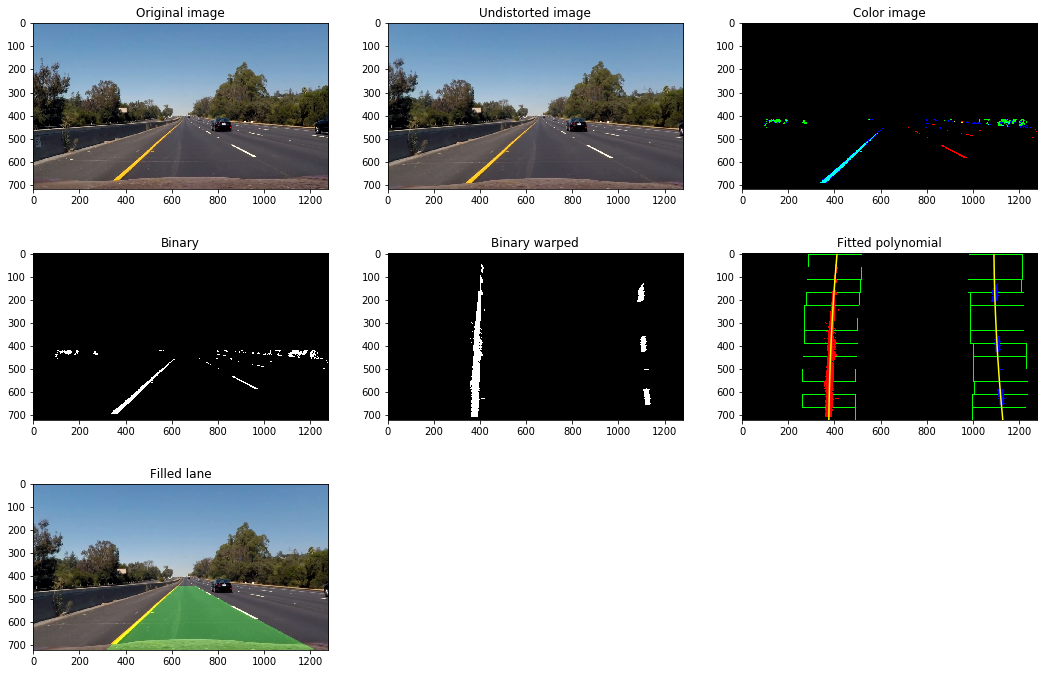

In [49]:
#img_idx = 6
#img = mpimg.imread(image_paths[img_idx])
test_img = clip1.get_frame(t)
print(t)
t += 0.04
img = test_img
_ = ld(img, display=True)
print(len(ld.prev_right_fitx))

## Video Processing    

### Project Video

In [51]:
white_output = 'output_videos/project_video_with_lanes_2.mp4'
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(5,8)
clip1 = VideoFileClip("project_video.mp4")

In [52]:
processed_clip1 = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time processed_clip1.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_with_lanes_2.mp4
[MoviePy] Writing video output_videos/project_video_with_lanes_2.mp4


100%|█████████▉| 1260/1261 [05:22<00:00,  3.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_with_lanes_2.mp4 

CPU times: user 2min 32s, sys: 43.8 s, total: 3min 15s
Wall time: 5min 25s


### Challenge Video

In [75]:
video_file = 'challenge_video'
white_output = 'output_videos/%s_with_lanes.mp4' % video_file
clip2 = VideoFileClip("%s.mp4" % video_file)

In [84]:
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video_with_lanes.mp4
[MoviePy] Writing video output_videos/challenge_video_with_lanes.mp4



100%|██████████| 485/485 [01:41<00:00,  4.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video_with_lanes.mp4 

CPU times: user 54.2 s, sys: 1.06 s, total: 55.3 s
Wall time: 1min 44s


In [28]:
clip2.duration * 133/485

4.428762886597938

In [71]:
t = 4.42

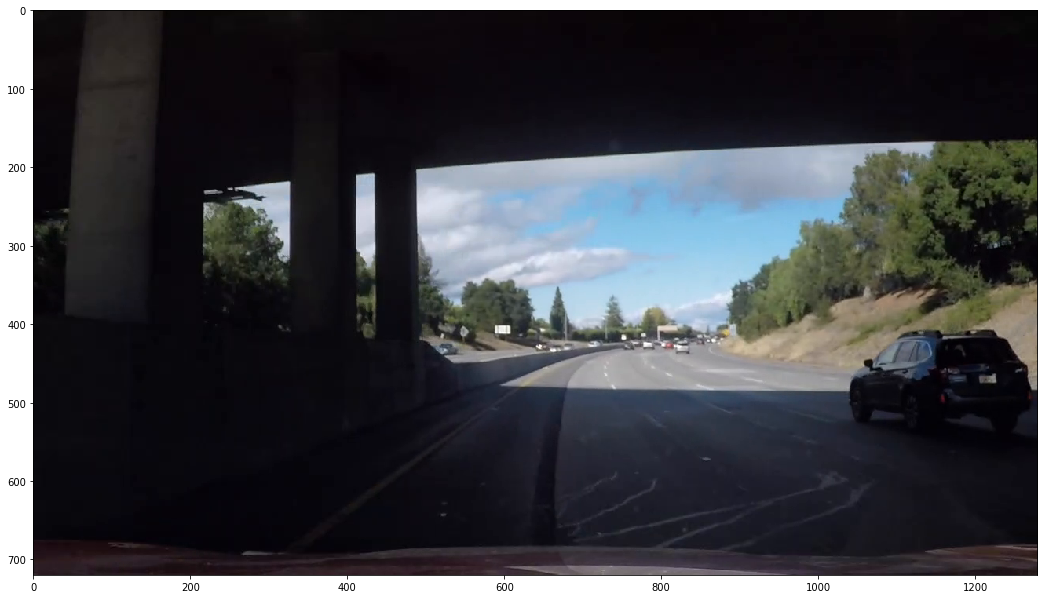

In [72]:
fig = plt.figure(figsize=(18, 16))
plt.imshow(test_img)

4.42
0


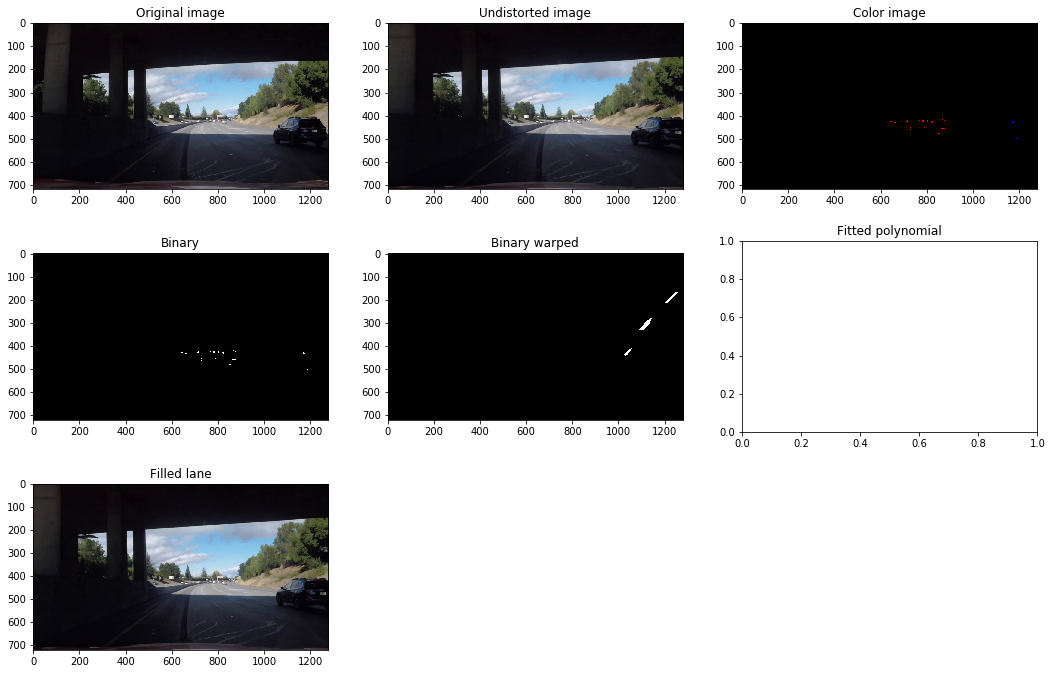

In [73]:
test_img = clip2.get_frame(t)
print(t)
t += 0.04
_ = ld(test_img, display=True)
print(len(ld.prev_right_fitx))

### Harder Challenge Video

In [86]:
video_file = 'harder_challenge_video'
white_output = 'output_videos/%s_with_lanes.mp4' % video_file
clip3 = VideoFileClip("%s.mp4" % video_file)

In [87]:
harder_challenge_clip = clip3.fl_image(process_image)
%time harder_challenge_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/harder_challenge_video_with_lanes.mp4
[MoviePy] Writing video output_videos/harder_challenge_video_with_lanes.mp4


100%|█████████▉| 1199/1200 [05:58<00:00,  3.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/harder_challenge_video_with_lanes.mp4 

CPU times: user 2min 44s, sys: 34.6 s, total: 3min 19s
Wall time: 6min 2s


In [98]:
t = 49.6

time = 49.60


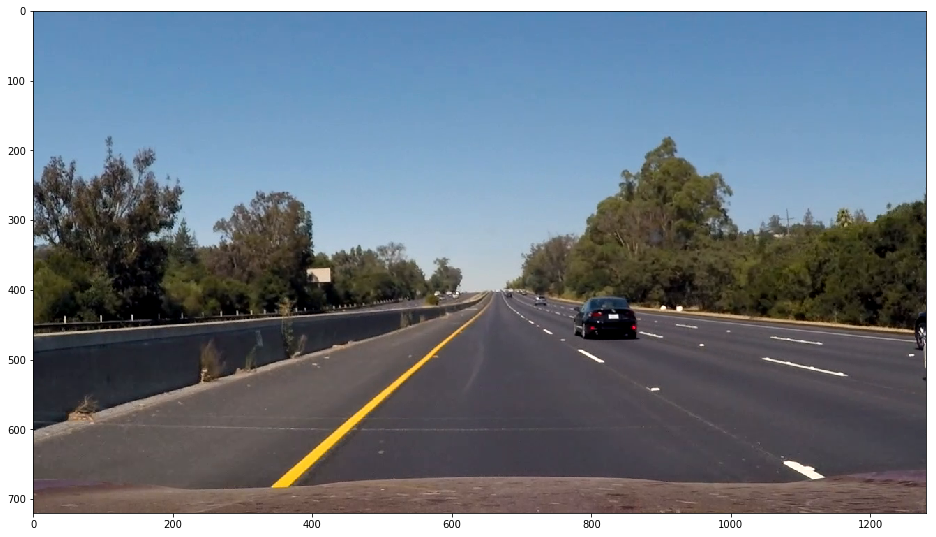

In [99]:
print("time = %.2f" % t)
fig = plt.figure(figsize=(16, 18))
test_img = clip1.get_frame(t)
t += 0.04
plt.imshow(test_img)

In [33]:
times = [
    36.9]

In [34]:
#t = 41.66
#fig = plt.figure(figsize=(16, 18))
for t in times:
    test_img = clip1.get_frame(t)
    #plt.imshow(process_image(test_img))
    scipy.misc.imsave('test_images/project_video_%d.jpg' % int(100*t), test_img)